![AI1.jpg](https://tdwi.org/-/media/TDWI/TDWI/BITW/AI1.jpg)


# Introducción
En este trabajo demostrare lo aprendido durante el curso en el ambito de la inteligencia artificial y en concreto machine learning, trabajare con el dataset Infartos, este dataset esta desequilibrado, y lo intentare mitigar con Smote, tambien me centrare en en la interpretabilidad del modelo al final aplicando librerias como lime shap y eli5

In [ ]:
#librerias que destacan
pip install eli5
pip install shap
pip install lime

Importe de la mayoria de las librerias que aplicare a lo largo del proyecto

In [1]:
import numpy as np 
import pandas as pd # procesado de datos, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
from imblearn.over_sampling import SMOTE
import scikitplot as skplt
import shap
import eli5
import lime
import lime.lime_tabular
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('./Data/healthcare-dataset-stroke-data.csv')
df.head(20)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [3]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

# Datos vacias
Está función la aplico para comprobar que datos son nulas, para ayudar con la metrica y la eficencia del modelo pretendo aplicar el uso del algoritmo Arbol de decisiones para para rellenar los valores nulas con datos simulados pero coherentes. No es obligatorio para el correcto funcionamiento del algoritmo, pero un dato como el indice de masa corporal (bmi) tiene mucha influencia en la prediccion, es decir contribuye a la precison general del modelo. Es una forma bastante interesante para abordar este problema, y me parece una forma perfecta para demostrar lo aprendido con la practica anterior

Procedo a aplicar Decision Tree para predicir los valores del atributo bmi(Indice de masa corporal)

In [4]:
DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [5]:
print('Valores vacias: ',sum(df.isnull().sum()))

Valores vacias:  0


Vemos que hemos conseguido reemplazar los valores vacios con valores aparentemente coherentes. Y ahora tenemos un dataset mas completa y por lo cual mas precisa a la hora de aplicar nuestro modelo.
Ahora procedo a analizar el dataset para determinar logicamente valores "pesados" del dataset y con pesados me refiero a datos mas influenciales a la hora de predicir las personas con un alto riesgo de infarto.

In [6]:
variables = [variable for variable in df.columns if variable not in ['id','stroke']]

conts = ['age','avg_glucose_level','bmi']

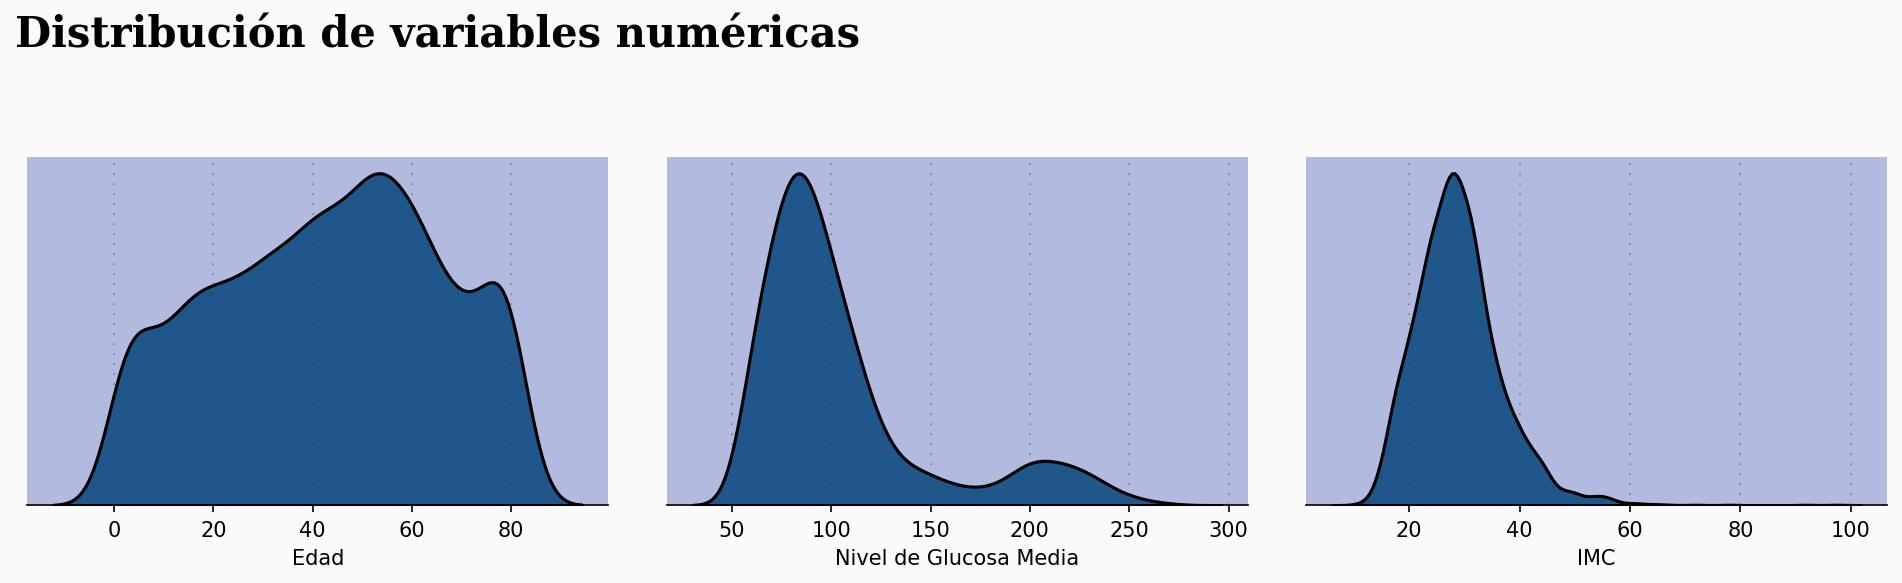

In [7]:
fig = plt.figure(figsize=(16, 16), dpi=150, facecolor='#fafafa')
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

background_color = "#B2BADF"

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0
for variable in conts:
        sns.kdeplot(df[variable] ,ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        #locals()["ax"+str(plot)].set_xlabel(variable) removed this for aesthetics
        plot += 1
        
ax0.set_xlabel('Edad')
ax1.set_xlabel('Nivel de Glucosa Media')
ax2.set_xlabel('IMC')


ax0.text(-20, 0.022, 'Distribución de variables numéricas', fontsize=20, fontweight='bold', fontfamily='serif')


plt.show()

Vemos una desviacion positiva en el IMC y el nivel de glucosa

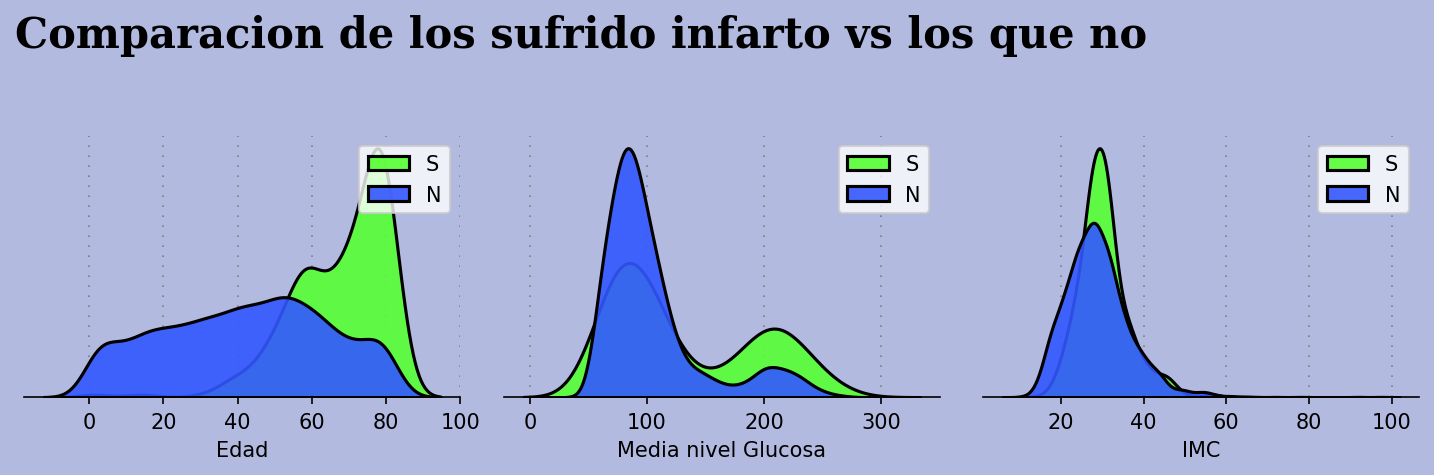

In [8]:
fig = plt.figure(figsize=(12, 12), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)


plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

s = df[df['stroke'] == 1]
ns = df[df['stroke'] == 0]

for feature in conts:
        sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#56FF33', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(ns[feature],ax=locals()["ax"+str(plot)], color='#3357FF', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
       
        plot += 1

ax0.set_xlabel('Edad')
ax1.set_xlabel('Media nivel Glucosa')
ax2.set_xlabel('IMC')
ax0.legend('SN')
ax1.legend('SN')
ax2.legend('SN')        
ax0.text(-20, 0.056, 'Comparacion de los sufrido infarto vs los que no', fontsize=20, fontweight='bold', fontfamily='serif')


plt.show()


Fijandonos en la edad vemos que es un factor destacable ya que varia bastante con respecto a gente con infarto contra los que no lo han sufrido.
Y aunque no tan obvio, existe una variacion tambien en Nivel de Glucosa y El Indice de masa Corporal

In [9]:
str_only = df[df['stroke'] == 1]
no_str_only = df[df['stroke'] == 0]

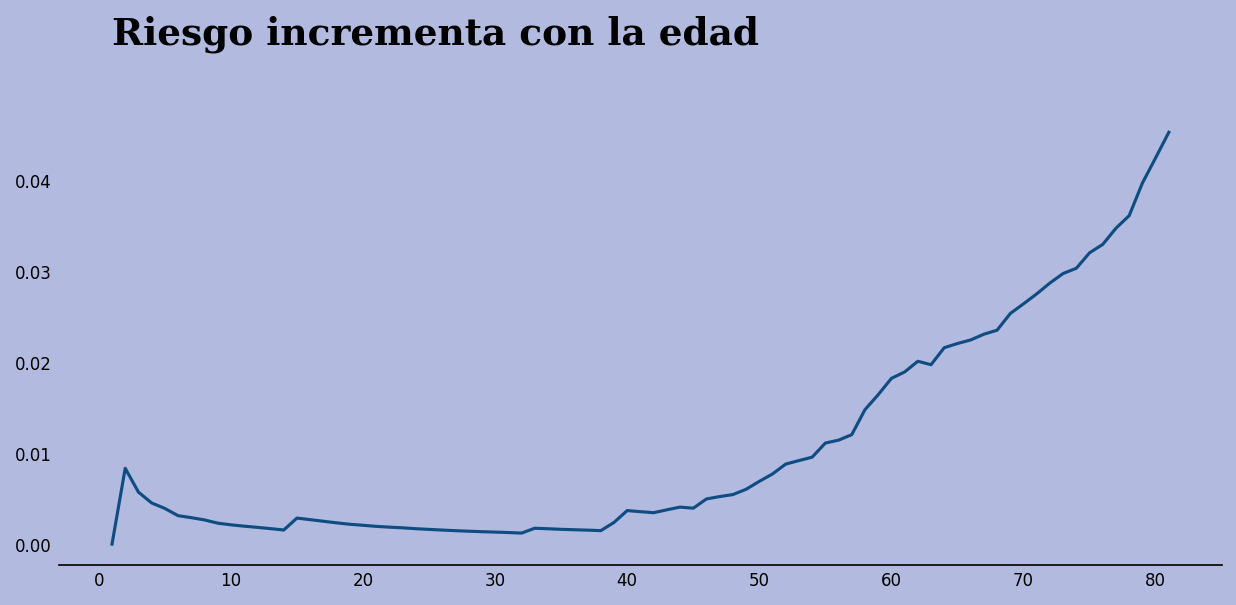

In [10]:
fig = plt.figure(figsize=(10, 10), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0.11, hspace=0.5)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)


df['age'] = df['age'].astype(int)

rate = []
for i in range(df['age'].min(), df['age'].max()):
    rate.append(df[df['age'] < i]['stroke'].sum() / len(df[df['age'] < i]['stroke']))

sns.lineplot(data=rate,color='#0f4c81',ax=ax0)

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)

ax0.tick_params(axis='both', which='major', labelsize=8)
ax0.tick_params(axis=u'both', which=u'both',length=0)

ax0.text(1,0.055,'Riesgo incrementa con la edad',fontsize=18,fontfamily='serif',fontweight='bold')



plt.show()

Vemos claramente que la edad es un factor importante para el riesgo de un infarto

In [11]:
#borrado de gender = other 
no_str_only = no_str_only[(no_str_only['gender'] != 'Other')]

A continuacion creo una compilacion de los datos para una perspectiva general del data set y ver cuales destacan

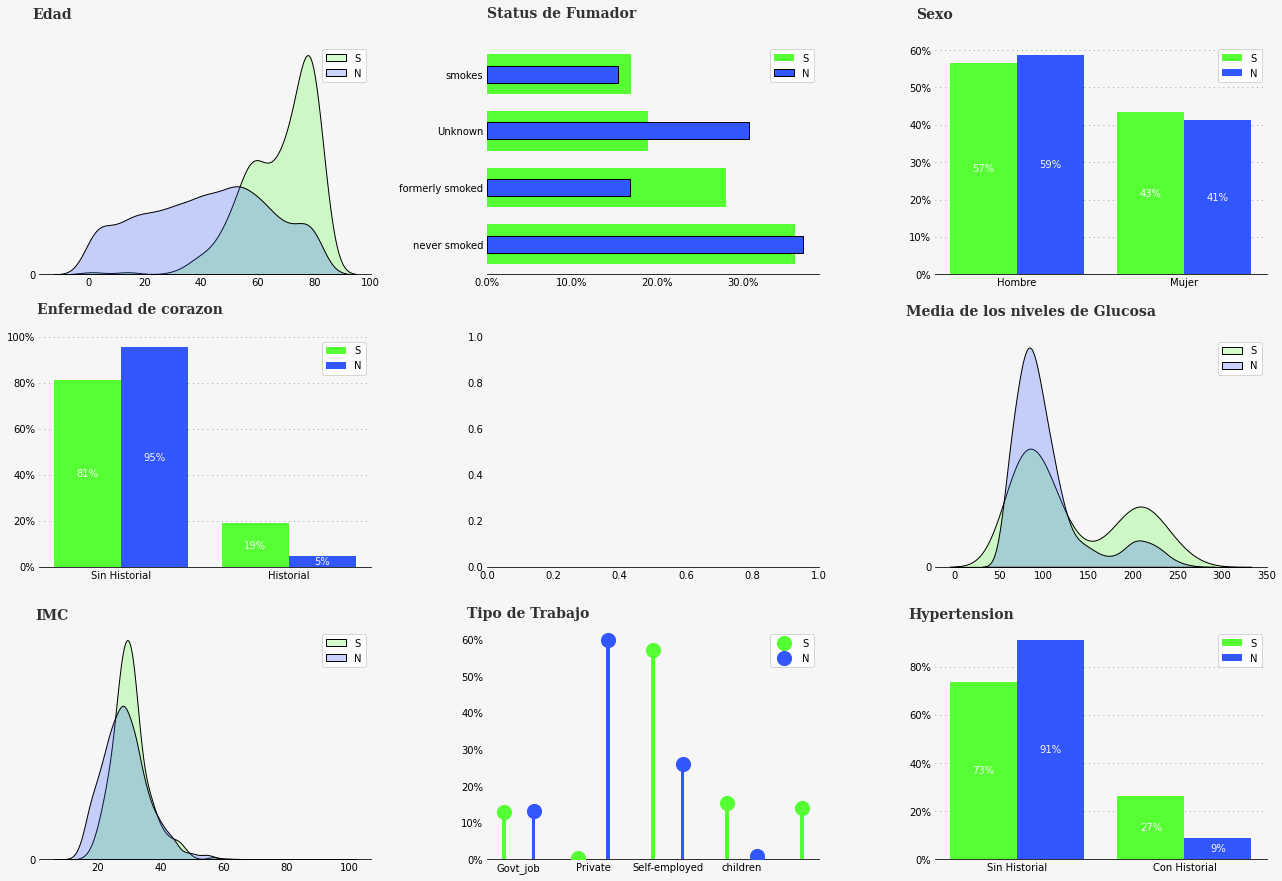

In [12]:
fig = plt.figure(figsize=(22,15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])

background_color = "#f6f6f6"
fig.patch.set_facecolor(background_color)

# Plots

## Edad
ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["age"])
negative = pd.DataFrame(no_str_only["age"])
sns.kdeplot(positive["age"], ax=ax0,color="#56FF33", shade=True, ec='black',label="positive")
sns.kdeplot(negative["age"], ax=ax0, color="#3357FF", shade=True, ec='black',label="negative")
ax0.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax0.set_ylabel('')    
ax0.set_xlabel('')
ax0.text(-20, 0.0465, 'Edad', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

# Fumador
positive = pd.DataFrame(str_only["smoking_status"].value_counts())
positive["Percentage"] = positive["smoking_status"].apply(lambda x: x/sum(positive["smoking_status"])*100)
negative = pd.DataFrame(no_str_only["smoking_status"].value_counts())
negative["Percentage"] = negative["smoking_status"].apply(lambda x: x/sum(negative["smoking_status"])*100)

ax1.text(0, 4, 'Status de Fumador', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax1.barh(positive.index, positive['Percentage'], color="#56FF33", zorder=3, height=0.7)
ax1.barh(negative.index, negative['Percentage'], color="#3357FF", zorder=3,ec='black', height=0.3)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.xaxis.set_major_locator(mtick.MultipleLocator(10))


#SEXO
positive = pd.DataFrame(str_only["gender"].value_counts())
positive["Percentage"] = positive["gender"].apply(lambda x: x/sum(positive["gender"])*100)
negative = pd.DataFrame(no_str_only["gender"].value_counts())
negative["Percentage"] = negative["gender"].apply(lambda x: x/sum(negative["gender"])*100)

x = np.arange(len(positive))
ax2.text(-0.4, 68.5, 'Sexo', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax2.bar(x, height=positive["Percentage"], zorder=3, color="#56FF33", width=0.4)
ax2.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#3357FF", width=0.4)
ax2.set_xticks(x + 0.4 / 2)
ax2.set_xticklabels(['Hombre','Mujer'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))
for i,j in zip([0, 1], positive["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

# Enfermedad del corazon
positive = pd.DataFrame(str_only["heart_disease"].value_counts())
positive["Percentage"] = positive["heart_disease"].apply(lambda x: x/sum(positive["heart_disease"])*100)
negative = pd.DataFrame(no_str_only["heart_disease"].value_counts())
negative["Percentage"] = negative["heart_disease"].apply(lambda x: x/sum(negative["heart_disease"])*100)

x = np.arange(len(positive))
ax3.text(-0.3, 110, 'Enfermedad de corazon', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax3.bar(x, height=positive["Percentage"], zorder=3, color="#56FF33", width=0.4)
ax3.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#3357FF", width=0.4)
ax3.set_xticks(x + 0.4 / 2)
ax3.set_xticklabels(['Sin Historial','Historial'])
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i,j in zip([0, 1], positive["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
    
# Glucosa
ax5.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["avg_glucose_level"])
negative = pd.DataFrame(no_str_only["avg_glucose_level"])
sns.kdeplot(positive["avg_glucose_level"], ax=ax5,color="#56FF33",ec='black', shade=True, label="positive")
sns.kdeplot(negative["avg_glucose_level"], ax=ax5, color="#3357FF", ec='black',shade=True, label="negative")
ax5.text(-55, 0.01855, 'Media de los niveles de Glucosa', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax5.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax5.set_ylabel('')    
ax5.set_xlabel('')

#IMC
ax6.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["bmi"])
negative = pd.DataFrame(no_str_only["bmi"])
sns.kdeplot(positive["bmi"], ax=ax6,color="#56FF33", ec='black',shade=True, label="positive")
sns.kdeplot(negative["bmi"], ax=ax6, color="#3357FF",ec='black', shade=True, label="negative")
ax6.text(-0.06, 0.09, 'IMC', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax6.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax6.set_ylabel('')    
ax6.set_xlabel('')


# Tipo de trabajo
positive = pd.DataFrame(str_only["work_type"].value_counts())
positive["Percentage"] = positive["work_type"].apply(lambda x: x/sum(positive["work_type"])*100)
positive = positive.sort_index()

negative = pd.DataFrame(no_str_only["work_type"].value_counts())
negative["Percentage"] = negative["work_type"].apply(lambda x: x/sum(negative["work_type"])*100)
negative = negative.sort_index()

ax7.bar(negative.index, height=negative["Percentage"], zorder=3, color="#56FF33", width=0.05)
ax7.scatter(negative.index, negative["Percentage"], zorder=3,s=200, color="#56FF33")
ax7.bar(np.arange(len(positive.index))+0.4, height=positive["Percentage"], zorder=3, color="#3357FF", width=0.05)
ax7.scatter(np.arange(len(positive.index))+0.4, positive["Percentage"], zorder=3,s=200, color="#3357FF")

ax7.yaxis.set_major_formatter(mtick.PercentFormatter())
ax7.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax7.set_xticks(np.arange(len(positive.index))+0.4 / 2)
ax7.set_xticklabels(list(positive.index),rotation=0)
ax7.text(-0.5, 66, 'Tipo de Trabajo', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

# hypertension
positive = pd.DataFrame(str_only["hypertension"].value_counts())
positive["Percentage"] = positive["hypertension"].apply(lambda x: x/sum(positive["hypertension"])*100)
negative = pd.DataFrame(no_str_only["hypertension"].value_counts())
negative["Percentage"] = negative["hypertension"].apply(lambda x: x/sum(negative["hypertension"])*100)

x = np.arange(len(positive))
ax8.text(-0.45, 100, 'Hypertension', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax8.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax8.bar(x, height=positive["Percentage"], zorder=3, color="#56FF33", width=0.4)
ax8.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#3357FF", width=0.4)
ax8.set_xticks(x + 0.4 / 2)
ax8.set_xticklabels(['Sin Historial','Con Historial'])
ax8.yaxis.set_major_formatter(mtick.PercentFormatter())
ax8.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i,j in zip([0, 1], positive["Percentage"]):
    ax8.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax8.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

ax0.legend('SN')
ax1.legend('SN')
ax2.legend('SN')
ax3.legend('SN')
ax5.legend('SN')
ax6.legend('SN')
ax7.legend('SN')
ax8.legend('SN')

for s in ["top","right","left"]:
    for i in range(0,9):
        locals()["ax"+str(i)].spines[s].set_visible(False)
        
for i in range(0,9):
        locals()["ax"+str(i)].set_facecolor(background_color)
        locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)
        locals()["ax"+str(i)].set_facecolor(background_color) 

        
plt.show()

In [13]:
# Codificando categorias a valores numericos

df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)

Ya estan definadas y representadas todos nuestros datos del dataset, empezamos con el proceso de entrenamiento con sklearn, definimos y separamos los datos en X: atributos e y: classification(Infarto o NO) empecemos con el modelo

Voy a aplicar la funcion Smote(), debido a que en un dataset como este, el caso de infarto se da bastante poco, en concreto, 1 de cada viente, es un data set bastante desequilibrado, la funcion smote ayudara a mitigar las inconsistencias en la presicion del modelo.

In [14]:
X  = df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']]
y = df['stroke']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

In [15]:
oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

Las variables que se miden en diferentes escalas no contribuyen por igual a la función de ajuste del modelo y aprendizaje del modelo y pueden terminar creando un sesgo. Por lo tanto, para hacer frente a este problema potencial, se suele utilizar la estandarización de características (μ=0, σ=1) antes del ajuste del modelo.

In [16]:
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])
logreg_cv = cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')

In [17]:
print('Logistic Regression mean :',cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())

Logistic Regression mean : 0.837032806401355


In [18]:
logreg_pipeline.fit(X_train_resh,y_train_resh)
logreg_pred   = logreg_pipeline.predict(X_test)
logreg_cm  = confusion_matrix(y_test,logreg_pred )
logreg_f1  = f1_score(y_test,logreg_pred)

In [19]:
print('Mean f1 scores:')
print('LR mean :',logreg_f1)

Mean f1 scores:
LR mean : 0.19999999999999998


In [20]:
from sklearn.metrics import plot_confusion_matrix, classification_report
print(classification_report(y_test,logreg_pred))
print('Accuracy Score: ',accuracy_score(y_test,logreg_pred))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      3404
           1       0.12      0.61      0.20       173

    accuracy                           0.76      3577
   macro avg       0.55      0.69      0.53      3577
weighted avg       0.93      0.76      0.83      3577

Accuracy Score:  0.7629298294660329


In [21]:
#utilizacion de eso parametros
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=0.1,penalty='l2',random_state=42))])
logreg_pipeline.fit(X_train_resh,y_train_resh)
logreg_tuned_pred = logreg_pipeline.predict(X_test)

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      3404
           1       0.12      0.61      0.20       173

    accuracy                           0.76      3577
   macro avg       0.55      0.69      0.53      3577
weighted avg       0.93      0.76      0.83      3577



<AxesSubplot:>

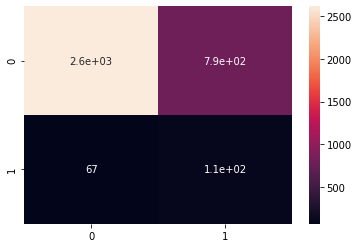

In [22]:
# Creacion de la matriz de confusion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
clf_rpt = classification_report(y_test,logreg_tuned_pred)
print(clf_rpt)
cm = confusion_matrix(y_test,logreg_tuned_pred)
sns.heatmap(cm,annot=True)

In [23]:
lr_df = pd.DataFrame(data=[f1_score(y_test,logreg_tuned_pred),accuracy_score(y_test, logreg_tuned_pred), recall_score(y_test, logreg_tuned_pred),
                   precision_score(y_test, logreg_tuned_pred), roc_auc_score(y_test, logreg_tuned_pred)], 
             columns=['Regression Logistica Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])


El área bajo la curva (AUC) es la medida de la capacidad de un clasificador para distinguir entre clases y se utiliza como resumen de la curva ROC. Cuanto mayor sea el AUC, mejor será el rendimiento del modelo para distinguir entre las clases positivas y negativas.

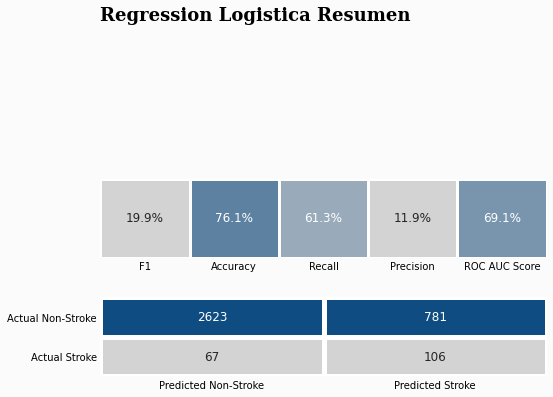

In [24]:
import matplotlib
colors = ["lightgray","lightgray","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(8,8)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])

sns.heatmap(lr_df.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95,yticklabels='', linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 

ax0.text(0,-2,'Regression Logistica Resumen',fontsize=18,fontweight='bold',fontfamily='serif')

ax0.tick_params(axis=u'both', which=u'both',length=0)



sns.heatmap(logreg_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax1,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],vmax=500,vmin=0,xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})
ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

Aplicacion de random forest,
alta precision pero baja recall, en este caso lo he implementado para poder enseñar algunos aspectos con el tema de la interpretabilidad y el peso de alguna de sus caracteristicas

In [25]:
rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
f_cv = cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
rf_pipeline.fit(X_train_resh,y_train_resh)


Pipeline(steps=[('scale', StandardScaler()),
                ('RF', RandomForestClassifier(random_state=42))])

In [26]:
rfc = RandomForestClassifier(max_features=2,n_estimators=100,bootstrap=True)

rfc.fit(X_train_resh,y_train_resh)

rfc_tuned_pred = rfc.predict(X_test)

In [27]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'Feature':df.columns, 'Importance':m.feature_importances_}).sort_values('Importance', ascending=False)


fi = rf_feat_importance(rf_pipeline['RF'], X)
fi[:10].style.background_gradient(cmap=colormap)

,Feature,Importance
1,age,0.401200
6,bmi,0.217564
5,avg_glucose_level,0.201186
4,work_type,0.077792
0,gender,0.064854
2,hypertension,0.024760
3,heart_disease,0.012644


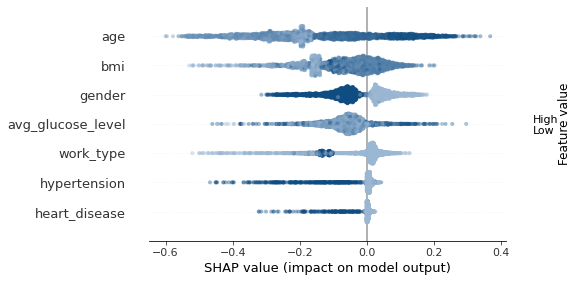

In [28]:

explainer = shap.TreeExplainer(rfc)
# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_test)
# custom colour plot
colors = ["#9bb7d4", "#0f4c81"]           
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
shap.summary_plot(shap_values[1], X_test,cmap=cmap,alpha=0.4)

Es Obvio el valor que tiene la edad, IMC y nivel de glucosa para la determinar el riesgo de un infarto

A continuacion vamos a interpretar los datos del modelo de regresion logistica aplicando Lime y eli5

In [29]:
#Muestra las prediciones
import lime
import lime.lime_tabular
# LIME
explainer = lime.lime_tabular.LimeTabularExplainer(X.values, feature_names=X.columns.values.tolist(),
                                                  class_names=['stroke'], verbose=True, mode='classification')
j = 1
exp = explainer.explain_instance(X.values[j], logreg_pipeline.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True)

Intercept 0.09608153385599938
Prediction_local [0.30636071]
Right: 0.4627428753411412


In [30]:
import eli5

columns_ = ['gender', 'age', 'hypertension', 'heart_disease', 'work_type',
       'avg_glucose_level', 'bmi']

eli5.show_weights(logreg_pipeline.named_steps["LR"], feature_names=columns_)

Weight?,Feature
+2.022,age
+0.240,bmi
+0.149,avg_glucose_level
-0.233,heart_disease
-0.357,work_type
-0.408,<BIAS>
-0.461,hypertension
-0.770,gender


Hemos conseguido interpretar el modelo de una forma coherente, y hemos podido destacar las caracteristicas mas importantes del modelo.